In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from keras import layers, models, losses, optimizers
from sklearn.preprocessing import StandardScaler
import numpy as np

In [388]:
df = pd.read_csv('./data/clean/df_total.csv')
df['DATE'] = pd.to_datetime(df['DATE'])
df = df.set_index('DATE')
df = df.resample('YE').mean()
df = df.reset_index().sort_values(by='DATE')
df = df[['DATE', 'PRENEI_Q', 'PRELIQ_Q', 'T_Q', 'FF_Q', 'Q_Q',
       'DLI_Q', 'SSI_Q', 'HU_Q', 'EVAP_Q', 'ETP_Q', 'PE_Q', 'SWI_Q',
       'DRAINC_Q', 'RUNC_Q', 'RESR_NEIGE_Q', 'RESR_NEIGE6_Q', 'HTEURNEIGE_Q',
       'HTEURNEIGE6_Q', 'HTEURNEIGEX_Q', 'SNOW_FRAC_Q', 'ECOULEMENT_Q',
       'WG_RACINE_Q', 'WGI_RACINE_Q', 'TINF_H_Q', 'TSUP_H_Q']]

<Axes: >

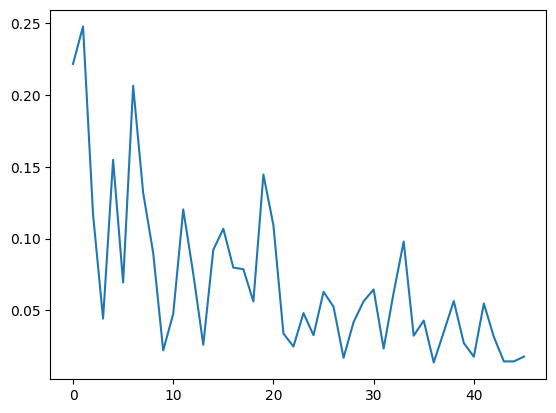

In [389]:
df['HTEURNEIGE_Q'].plot()

In [390]:
def transform_to_supervised(df, datetime_col, feature_cols, target_col, n_past=3, n_future=1):

    df = df.copy()
    df.sort_values(by=datetime_col, inplace=True)
    df.reset_index(drop=True, inplace=True)

    supervised = pd.DataFrame()

    for col in feature_cols:
        for i in range(n_past, 0, -1):
            supervised[f'{col}(t-{i})'] = df[col].shift(i)

    for i in range(0, n_future):
        supervised[f'{target_col}(t+{i})'] = df[target_col].shift(-i)

    supervised.dropna(inplace=True)

    return supervised

In [391]:
df_supervised = transform_to_supervised(df, 'DATE', ['PRENEI_Q', 'PRELIQ_Q', 'T_Q', 'FF_Q', 'Q_Q',
       'DLI_Q', 'SSI_Q', 'HU_Q', 'EVAP_Q', 'ETP_Q', 'PE_Q', 'SWI_Q',
       'DRAINC_Q', 'RUNC_Q', 'RESR_NEIGE_Q', 'RESR_NEIGE6_Q', 'HTEURNEIGE_Q',
       'HTEURNEIGE6_Q', 'HTEURNEIGEX_Q', 'SNOW_FRAC_Q', 'ECOULEMENT_Q',
       'WG_RACINE_Q', 'WGI_RACINE_Q', 'TINF_H_Q', 'TSUP_H_Q'], 'HTEURNEIGE_Q', n_past=3, n_future=1)

In [392]:
X = df_supervised.iloc[:,:-1].copy()
y = df_supervised.iloc[:,-1].copy()

In [393]:
X_train, X_test = X[:int(len(X)*0.8)], X[int(len(X)*0.8):]
y_train, y_test = y[:int(len(X)*0.8)], y[int(len(X)*0.8):]

In [394]:
scaler_x = StandardScaler()
scaler_y = StandardScaler()

X_train_scaled = scaler_x.fit_transform(X_train)
X_test_scaled = scaler_x.transform(X_test)

# y_train_scaled = scaler_y.fit_transform(pd.DataFrame(y_train))
# y_test_scaled = scaler_y.transform(pd.DataFrame(y_test))
y_train_scaled = pd.DataFrame(y_train)
y_test_scaled = pd.DataFrame(y_test)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
0.026412576285117124


c:\Users\dmitrii.druzhbin\AppData\Local\miniconda3\envs\snowcast\Lib\site-packages\sklearn\utils\validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


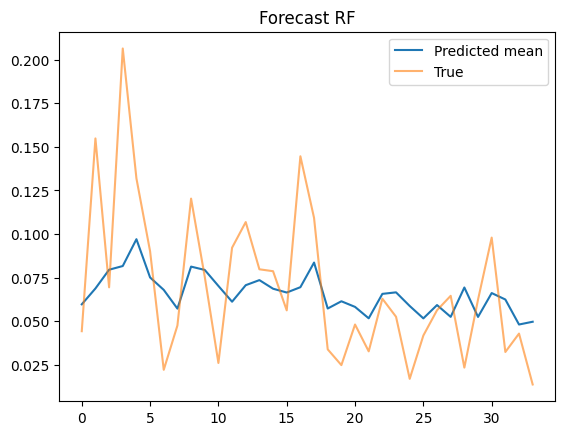

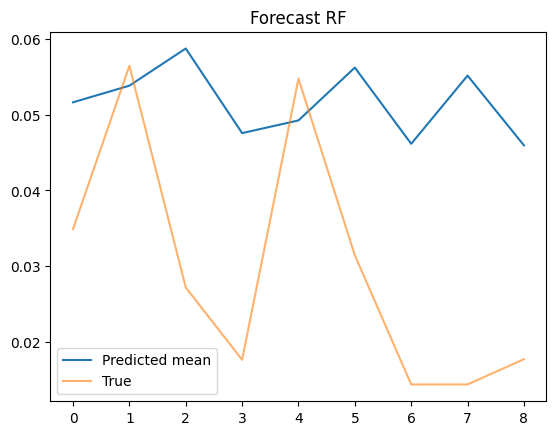

In [395]:
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.svm import SVR
from sklearn.metrics import root_mean_squared_error

# param_grid = {
#     'n_estimators': [50, 100],
#     'max_depth': [None, 5, 10, 20],
#     'min_samples_split': [2, 5, 10, 15],
#     'min_samples_leaf': [1, 2, 4, 5],
#     'bootstrap': [True, False]
# }

# param_grid = {
#     'n_estimators': [50, 100],
#     'max_depth': [2, 3, 6, 9],
#     'learning_rate': [0.01, 0.1],
#     'subsample': [0.8, 1.0],
#     'colsample_bytree': [0.8, 1.0],
# }

param_grid = {
    'kernel': ['rbf'],  # or 'linear', 'poly', 'sigmoid'
    'C': [0.1, 1, 10, 100],  # Regularization strength
    'epsilon': [0.01, 0.1, 0.2],  # Tube size for no penalty
    'gamma': ['scale', 0.1, 0.01, 0.001]  # Kernel coefficient
}


model_rf = RandomForestRegressor(random_state=42)
model_xgb = XGBRegressor(random_state=42, n_jobs=-1)
model_svm = SVR()

tscv = TimeSeriesSplit(n_splits=5)

grid_search = GridSearchCV(
    estimator=model_svm,
    param_grid=param_grid,
    cv=tscv,
    scoring='neg_mean_squared_error',
    verbose=2,
    n_jobs=-1
)


grid_search.fit(X_train_scaled, y_train_scaled)

best_model = grid_search.best_estimator_

# best_model = model_xgb.fit(X_train_scaled, y_train_scaled)

yhat = best_model.predict(X_test_scaled)
yhat_train = best_model.predict(X_train_scaled)


print(root_mean_squared_error(y_test_scaled, yhat))

plt.plot(yhat_train, label='Predicted mean')
# plt.fill_between(range(len(mu_pred_test)),
#                  mu_pred_test - 1.96 * sigma_test,
#                  mu_pred_test + 1.96 * sigma_test,
#                  alpha=0.3, label='95% CI')
plt.plot(y_train_scaled.reset_index(drop=True), label='True', alpha=0.6)
plt.legend()
plt.title("Forecast RF")
plt.show()


plt.plot(yhat, label='Predicted mean')
# plt.fill_between(range(len(mu_pred_test)),
#                  mu_pred_test - 1.96 * sigma_test,
#                  mu_pred_test + 1.96 * sigma_test,
#                  alpha=0.3, label='95% CI')
plt.plot(y_test_scaled.reset_index(drop=True), label='True', alpha=0.6)
plt.legend()
plt.title("Forecast RF")
plt.show()


In [290]:
def create_lstm_sequences(X, y, timesteps):

    X_seq, y_seq = [], []
    for i in range(timesteps, len(X)):
        X_seq.append(X[i - timesteps:i])
        y_seq.append(y[i])
    return np.array(X_seq), np.array(y_seq)

In [291]:
df_lstm = df.drop(columns='DATE').dropna()

In [292]:
X=df_lstm.copy()
y=df_lstm[['HTEURNEIGE_Q']]

In [293]:
X_train, X_test = X[:int(len(X)*0.8)], X[int(len(X)*0.8):]
y_train, y_test = y[:int(len(X)*0.8)], y[int(len(X)*0.8):]

In [294]:
scaler_x = StandardScaler()
scaler_y = StandardScaler()

X_train_scaled = scaler_x.fit_transform(X_train)
X_test_scaled = scaler_x.transform(X_test)

# y_train_scaled = scaler_y.fit_transform(pd.DataFrame(y_train))
# y_test_scaled = scaler_y.transform(pd.DataFrame(y_test))
y_train_scaled = pd.DataFrame(y_train)
y_test_scaled = pd.DataFrame(y_test)

In [295]:
y_train_scaled.shape

(36, 1)

In [296]:
X_lstm, y_lstm = create_lstm_sequences(X=X_train_scaled, y=y_train_scaled.values, timesteps=4)

In [297]:
X_test_lstm, y_test_lstm = create_lstm_sequences(X=X_test_scaled, y=y_test_scaled.values, timesteps=4)

In [298]:
def build_probabilistic_model_30days(timesteps, features):
    inputs = layers.Input(shape=(timesteps, features))

    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True))(inputs)
    x = layers.Conv1D(128, kernel_size=4, activation='relu', padding='causal')(x)
    x = layers.MaxPool1D()(x)
    x = layers.LSTM(256, return_sequences=True)(x)
    x = layers.LSTM(64)(x)

    # x = layers.Dense(16, activation='relu')(x)
    x = layers.Dense(32, activation='relu')(x)
    # x = layers.Dense(64, activation='relu')(x)
    

    mu = layers.Dense(1)(x)
    sigma = layers.Dense(1, activation='softplus')(x)  # softplus to ensure σ > 0

    outputs = layers.Concatenate()([mu, sigma])
    model = models.Model(inputs, outputs)
    return model

# Custom loss function for Gaussian NLL
def gaussian_nll(y_true, y_pred):
    mu = y_pred[:, 0]
    sigma = y_pred[:, 1] + 1e-6  # avoid log(0)
    return tf.reduce_mean(0.5 * tf.math.log(2 * np.pi * sigma**2) + (tf.squeeze(y_true) - mu)**2 / (2 * sigma**2))

In [299]:
model = build_probabilistic_model_30days(X_lstm.shape[1], X_lstm.shape[2])
model.compile(optimizer='adam', loss=gaussian_nll)
model.fit(X_lstm, y_lstm, epochs=50, batch_size=24, verbose=1, validation_data=[X_test_lstm, y_test_lstm])

Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 394ms/step - loss: 0.5545 - val_loss: 0.4830
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.5115 - val_loss: 0.3998
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.4423 - val_loss: 0.2580
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.3233 - val_loss: -0.0802
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0843 - val_loss: -0.4000
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: -0.2988 - val_loss: -1.3785
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: -0.8150 - val_loss: -0.3793
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0701 - val_loss: -0.3940
Epoch 9/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.1211 - val_loss: 5.6826
Epoch 10/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.4991 - val_loss: -1.3266
Epoch 11/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: -0.9590 - val_loss: -1.0474
Epoch 12/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: -0.6260 - val_lo

In [300]:
yhat = model.predict(X_lstm)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step


In [301]:
mu_pred = yhat[:, 0]
sigma_pred = yhat[:, 1]

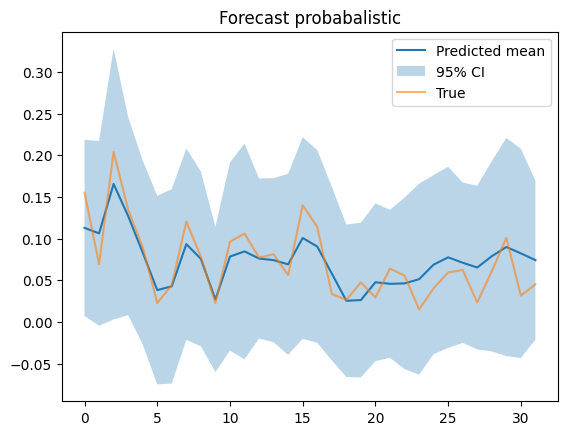

In [302]:
plt.plot(mu_pred, label='Predicted mean')
plt.fill_between(range(len(mu_pred)),
                 mu_pred - 1.96 * sigma_pred,
                 mu_pred + 1.96 * sigma_pred,
                 alpha=0.3, label='95% CI')
plt.plot(y_lstm[:,0], label='True', alpha=0.6)
plt.legend()
plt.title("Forecast probabalistic")
plt.show()

In [303]:
yhat_test = model.predict(X_test_lstm)
mu_pred_test = yhat_test[:, 0]
sigma_test = yhat_test[:, 1]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step


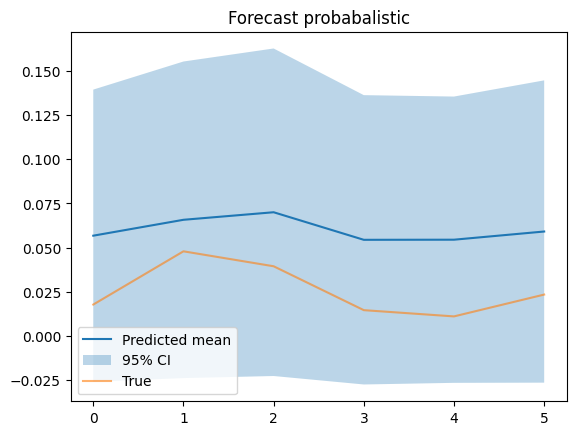

In [304]:
plt.plot(mu_pred_test, label='Predicted mean')
plt.fill_between(range(len(mu_pred_test)),
                 mu_pred_test - 1.96 * sigma_test,
                 mu_pred_test + 1.96 * sigma_test,
                 alpha=0.3, label='95% CI')
plt.plot(y_test_lstm[:,0], label='True', alpha=0.6)
plt.legend()
plt.title("Forecast probabalistic")
plt.show()

In [279]:
ytrue = y_test_lstm.ravel()

In [280]:
from sklearn.metrics import root_mean_squared_error

root_mean_squared_error(ytrue, mu_pred_test)

0.008307070579385647

In [281]:
import joblib

In [282]:
ndays = 1
model.save(f'model_{ndays}days.keras')
joblib.dump(scaler_y, f'scaler_y_{ndays}days.pkl')
joblib.dump(scaler_x, f'scaler_x_{ndays}days.pkl')

['scaler_x_1days.pkl']

In [54]:
joblib.dump(scaler_y, 'scaler_y_30days.pkl')

['scaler_y_30days.pkl']